In [1]:
#%%
try:
    get_ipython().magic(u'load_ext autoreload')
    get_ipython().magic(u'autoreload 2')
    print(1)
except:
    print('NOT IPYTHON')

import sys
import numpy as np
import psutil
from scipy.ndimage.filters import gaussian_filter
from ipyparallel import Client

import caiman as cm
from caiman.utils.visualization import nb_view_patches3d
import caiman.source_extraction.cnmf as cnmf
from caiman.components_evaluation import evaluate_components

import matplotlib.pyplot as plt
import bokeh.plotting as bpl
bpl.output_notebook()

1


Loading BokehJS ...

In [2]:
#%%
n_processes = psutil.cpu_count()
print('using ' + str(n_processes) + ' processes')
print("Stopping  cluster to avoid unnencessary use of memory....")
sys.stdout.flush()  
cm.stop_server()

using 24 processes
Stopping  cluster to avoid unnencessary use of memory....
Stopping cluster...
NOT SLURM
No cluster to stop... done


In [3]:
def gen_data(p=1, noise=1., T=256, framerate=30, firerate=2., plot=False):
    if p == 2:
        gamma = np.array([1.5, -.55])
    elif p == 1:
        gamma = np.array([.9])
    else:
        raise
    dims = (30, 40, 50)  # size of image
    sig = (2, 2, 2)  # neurons size
    bkgrd = 10
    N = 20  # number of neurons
    np.random.seed(7)
    centers = np.asarray([[np.random.randint(5, x - 5)
                           for x in dims] for i in range(N)])
    Yr = np.zeros(dims + (T,), dtype=np.float32)
    trueSpikes = np.random.rand(N, T) < firerate / float(framerate)
    trueSpikes[:, 0] = 0
    truth = trueSpikes.astype(np.float32)
    for i in range(2, T):
        if p == 2:
            truth[:, i] += gamma[0] * truth[:, i - 1] + gamma[1] * truth[:, i - 2]
        else:
            truth[:, i] += gamma[0] * truth[:, i - 1]
    for i in range(N):
        Yr[centers[i, 0], centers[i, 1], centers[i, 2]] = truth[i]
    tmp = np.zeros(dims)
    tmp[15, 20, 25] = 1.
    z = np.linalg.norm(gaussian_filter(tmp, sig).ravel())
    Yr = bkgrd + noise * np.random.randn(*(dims + (T,))) + 10 * gaussian_filter(Yr, sig + (0,)) / z
    d1, d2, d3, T = Yr.shape
    Yr = np.reshape(Yr, (d1 * d2 * d3, T), order='F').astype(np.float32)

    if plot:
        Y = np.reshape(Yr, (d1, d2, d3, T), order='F')
        plt.figure(figsize=(15, 3))
        plt.plot(truth.T)
        plt.figure(figsize=(15, 3))
        for c in centers:
            plt.plot(Y[c[0], c[1], c[2]])

        plt.figure(figsize=(15, 4))
        plt.subplot(131)
        plt.scatter(*centers.T[::-1], c='g')
        plt.imshow(Y.max(0).max(-1), cmap='hot')
        plt.title('Max.proj. x & t')
        plt.subplot(132)
        plt.scatter(*centers.T[[2, 0, 1]], c='g')
        plt.imshow(Y.max(1).max(-1), cmap='hot')
        plt.title('Max.proj. y & t')
        plt.subplot(133)
        plt.scatter(*centers.T[[1, 0, 2]], c='g')
        plt.imshow(Y.max(2).max(-1), cmap='hot')
        plt.title('Max.proj. z & t')
        plt.show()

    return Yr, truth, trueSpikes, centers, dims

In [4]:
plt.close('all')
#%% SAVING TIFF FILE ON A SINGLE MEMORY MAPPABLE FILE
try:
    fname_new = cm.save_memmap(['/mnt/ceph/users/agiovann/ImagingData/Yassum_23slice12frame.tif'], base_name='Yr', is_3D=True)
except:  # %% create 3d tiff file if not yet existent
    from skimage.external.tifffile import imsave
    Yr, truth, trueSpikes, centers, dims = gen_data(p=2)
    data = np.transpose(Yr.reshape(dims + (-1,), order='F'), [3, 0, 1, 2])
    imsave('example_movies/demoMovie3D.tif', data)
    fname_new = cm.save_memmap(['example_movies/demoMovie3D.tif'], base_name='Yr', is_3D=True)

print(fname_new)

/mnt/ceph/users/agiovann/ImagingData/Yassum_23slice12frame.tif
/mnt/ceph/users/agiovann/ImagingData/Yr_d1_23_d2_770_d3_708_order_F_frames_12_.mmap


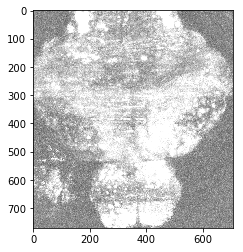

In [5]:
Yr, dims, T = cm.load_memmap(fname_new)
Y = np.reshape(Yr, dims + (T,), order='F')
Cn = cm.local_correlations(Y)
plt.imshow(Cn.max(0) if len(Cn.shape) == 3 else Cn, cmap='gray',
           vmin=np.percentile(Cn, 1), vmax=np.percentile(Cn, 99))
plt.show()

## Single patch 

In [7]:
# START CLUSTER
cm.start_server()
c = Client()

Starting cluster...Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
......

In [9]:
# FIT
images = np.reshape(Yr.T, [T] + list(dims), order='F')


(12, 23, 770, 708)
using 24 processes
using 4000 pixels per process
using 20000 block_size
[23, 30, 30]
You may think that it went well but reality is harsh
93.8641040325
Transforming patches into full matrix
Skipped %d Empty Patch 0
Generating background


LinAlgError: Singular matrix

In [ ]:
# set parameters
K = 20  # number of neurons expected per patch
gSig = [2, 2, 2]  # expected half size of neurons
merge_thresh = 0.8  # merging threshold, max correlation allowed
p = 2  # order of the autoregressive system

In [ ]:
# INIT
cnm = cnmf.CNMF(n_processes, method_init='greedy_roi', k=K, gSig=gSig, merge_thresh=merge_thresh,
                p=p, dview=c[:], Ain=None, method_deconvolution='oasis')
cnm = cnm.fit(images)

In [ ]:
# view components per layer
traces_fluo = nb_view_patches3d(cnm.YrA, cnm.A, cnm.C,dims, thr=0.9,image_type='max', max_projection=False, denoised_color='red')

## Multi patch

In [10]:
rf = (15, 15, 15)  # half-size of the patches in pixels. rf=25, patches are 50x50
stride = (10, 10, 10)  # amounpl.it of overlap between the patches in pixels
K = 5  # number of neurons expected per patch
gSig = [3, 3, 3]  # expected half size of neurons
merge_thresh = 0.8  # merging threshold, max correlation allowed
p = 2  # order of the autoregressive system
save_results = False
#%% RUN ALGORITHM ON PATCHES
init_method = 'greedy_roi'
alpha_snmf = None  # 10e2  # this controls sparsity

cnm = cnmf.CNMF(n_processes, k=K, gSig=gSig, merge_thresh=0.8, p=p, dview=c[:], Ain=None, rf=rf, stride=stride, memory_fact=1,
                method_init=init_method, alpha_snmf=alpha_snmf, only_init_patch=True, gnb=1, method_deconvolution='oasis')
cnm = cnm.fit(images)

A_tot = cnm.A
C_tot = cnm.C
YrA_tot = cnm.YrA
b_tot = cnm.b
f_tot = cnm.f
sn_tot = cnm.sn

print(('Number of components:' + str(A_tot.shape[-1])))

(12, 23, 770, 708)
using 24 processes
using 4000 pixels per process
using 20000 block_size
[23, 30, 30]
You may think that it went well but reality is harsh
92.3176641464
Transforming patches into full matrix
Skipped %d Empty Patch 0
Generating background


LinAlgError: Singular matrix

In [ ]:
# evaluate_components
final_frate = 10  # approx final rate  (after eventual downsampling )
Npeaks = 10
traces = C_tot + YrA_tot
#        traces_a=traces-scipy.ndimage.percentile_filter(traces,8,size=[1,np.shape(traces)[-1]/5])
#        traces_b=np.diff(traces,axis=1)
fitness_raw, fitness_delta, erfc_raw, erfc_delta, r_values, significant_samples = evaluate_components(
    Y, traces, A_tot, C_tot, b_tot, f_tot, final_frate, remove_baseline=True, N=5, robust_std=False, Athresh=0.1, Npeaks=Npeaks,  thresh_C=0.3)

idx_components_r = np.where(r_values >= .7)[0]
idx_components_raw = np.where(fitness_raw < -60)[0]
idx_components_delta = np.where(fitness_delta < -20)[0]

idx_components = np.union1d(idx_components_r, idx_components_raw)
idx_components = np.union1d(idx_components, idx_components_delta)
idx_components_bad = np.setdiff1d(list(range(len(traces))), idx_components)

print(('Keeping ' + str(len(idx_components)) +
       ' and discarding  ' + str(len(idx_components_bad))))

In [ ]:
A_tot = A_tot.tocsc()[:, idx_components]
C_tot = C_tot[idx_components]

In [ ]:
# fit good components again
cnm = cnmf.CNMF(n_processes, k=A_tot.shape, gSig=gSig, merge_thresh=merge_thresh, p=p, dview=c[:],
                Ain=A_tot, Cin=C_tot, f_in=f_tot, rf=None, stride=None, method_deconvolution='oasis')
cnm = cnm.fit(images)

In [ ]:
# view components per layer
traces_fluo = nb_view_patches3d(cnm.YrA, cnm.A, cnm.C, dims, Yr=Yr,
                                image_type='corr', denoised_color='green')

In [ ]:
# STOP CLUSTER
cm.stop_server()